In [1]:
import os
import pandas as pd
import seaborn as sns
import string
import re
from collections import defaultdict
from helper_functions import group_sort, unique_values, freq_stats_corpora


sns.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Mission
Développer un système de suggestion de tag pour le site stackoverflow

# Load Data

In [2]:
cur_dir = os.path.dirname(os.getcwd())
num_db = 1
df = pd.DataFrame([])

for i in range(num_db):
    df = df.append(
        pd.read_csv(
            cur_dir + "/db/QueryResults%d.csv" % (i + 1), index_col=0))

In [3]:
df.shape

(50000, 21)

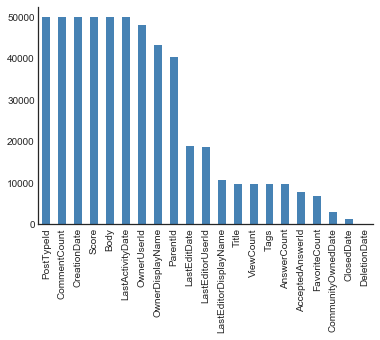

In [4]:
df_count = df.count().sort_values(ascending=False)
fig, ax = plt.subplots()
df_count.plot.bar(color="steelblue", ax=ax)
sns.despine()

__Observation__:
- Each post has an id, PostTypeId, CommentCount, CreationDate, Score and LastActivityDate
- User information are given by OwnerUserId and OwnerDisplayName, almost all posts are given by distinct user.
- Tags have a significant missing values -> users do not tag much

Here, we are interested in analysing the title and body and then suggest tags to users.

In the *unsupervised learning*, tags are not necessary, but in *supervised learning*, tags are the target variable.

In [5]:
# Combine columns
# add an empty space for distinction
df_text = pd.DataFrame(list(zip(df.Title,
                                df.Body)), index = df.index).rename(columns={
                                    0: 'TITLE',
                                    1: 'BODY'
                                })

In [6]:
def stringbetweencode(data):
    p = re.compile("<code>(.+?)<\/code>", flags=re.DOTALL)
    return p.findall(data) 

#df_text["CODE"] = np.nan
df_text["CODE"] = df_text["BODY"].apply(stringbetweencode) 

# EDA for Tags

In [7]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize

def tag_between_brackets(data):
    p = re.compile(r'<(.*?)>')
    return p.findall(data)

# extract only data with tags
df_tags = df[df.Tags.notnull()].Tags

# extact tags between <>
df_stags = df_tags.apply(tag_between_brackets)

# combine all tokens together for freq dist
tagslist = df_stags.sum()

# count frequency of each tag
# How many documents are tagged with a specific tag?
tagsfreq = FreqDist(tagslist)

In [8]:
from operator import itemgetter
# sort by values in descending order
sorted_tagsfreq = sorted(tagsfreq.items(), key=itemgetter(1), reverse=True)
tags_key, tags_value = zip(*sorted_tagsfreq)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


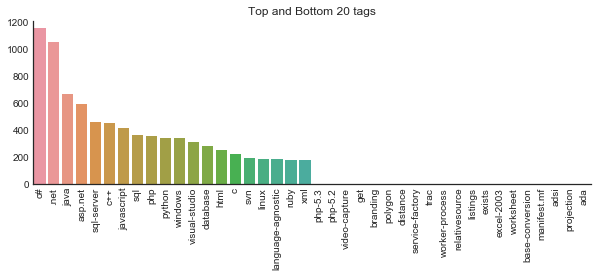

In [9]:
# prepare for sns.barplot
fig, ax = plt.subplots( figsize=(10, 3))

n_element = 20
x_tags = np.array(tags_key[:n_element]+ tags_key[-n_element:])
y_tags = np.array(tags_value[:n_element]+ tags_value[-n_element:])
sns.barplot(x_tags, y_tags, ax=ax)
ax.set_xticklabels(x_tags, rotation=90)
ax.set_title('Top and Bottom 20 tags')
sns.despine()

In [199]:
pd.Series(tags_value).describe([0.5, 0.75,0.9,0.95])

count    3745.000000
mean        7.397597
std        37.596823
min         1.000000
50%         1.000000
75%         4.000000
90%        11.000000
95%        24.000000
max      1152.000000
dtype: float64

__Observation__:
- 50% of the tags only occur once, we will eliminate tags that have low counts, taking the arg of 75% as threshold

### Remove low count tags 

In [224]:
def remove_low_count_tags(data):
    reduced = [el for el in data if el in set(tags_key_reduced)]

    if not reduced:
        reduced = np.NaN
    return reduced

# drop keywords that have less than tag_freq
quartile = 0.95
n_tag = pd.Series(tags_value).quantile([quartile]).values[0]
sorted_tagsfreq_reduced = [el for el in sorted_tagsfreq if el[1] > n_tag]
tags_key_reduced, tags_value_reduced = zip(*sorted_tagsfreq_reduced)
df_stags_temp = df_stags.apply(remove_low_count_tags)
df_stags_reduced = df_stags_temp[df_stags_temp.notnull()]

# Text preprocessing with scikit learn and NLTK

In [275]:
from sklearn.decomposition import LatentDirichletAllocation
from nltk import regexp_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pdb
wnl = WordNetLemmatizer()


def convert_tag(tag):
    """
    Convert the tag given by nltk.pos_tag 
    to the tag used by wordnet.synsets
    """
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        # defalut value
        return None


def lemmatizer(doc):
    """
    returns lemmatized tokens after removing stop words and pos tagging
    
    Parameters:
    -----------
    doc: pandas dataframe
        text description in df
    
    Return:
    -------
    pandas dataframe
        lemmatized, pos_tagged, and removed stopwords tokens
    """
    # add words to stoplist, previously punctuations have been removed,
    # so we should do the same for the stoplist
    stoplist = [striphtmlpunct(x) for x in stopwords.words('english')] + ['im']
    #stoplist = stopwords.words('english') + [
    #    "i've", "either", "i'm", "i'd", "would", "could", 'it', "like",
    #    "something", "also", "might", "want", 'this', 'make', 'sure'
    #]
   
    lemmatized = []

    regex_tokens = regexp_tokenize(doc, pattern='\w+\S+|\.\w+')

    for word, p_tags in pos_tag(regex_tokens):
        if word not in set(stoplist):
            convert_pos_tag = convert_tag(p_tags)

            # retain nouns only
            if convert_pos_tag == 'n':
                lemmatized.append(wnl.lemmatize(word, pos=convert_pos_tag))
    return lemmatized


def striphtmlpunct(data):
    # remove html tags, code unnecessary punctuations
    # <.*?> to remove everything between <>
    # [^\w\s+\.\-\#\+] remove punctuations except .-#+
    # (\.{1,3})(?!\S) negative lookahead assertion: only match .{1,3} that 
    # is followed by white space
    p = re.compile(r'<.*?>|[^\w\s+\.\-\#\+]')
    res = p.sub('', data)
    pe = re.compile('(\.{1,3})(?!\S)')
    return pe.sub('', res)


def striptabs(data):
    # remove tabs breaklines
    p = re.compile(r'(\r\n)+|\r+|\n+|\t+/i')
    return p.sub(' ', data)


# remove html tags
df_text["BODY_STRIPPED"] = df_text.BODY.str.lower().apply(
    striphtmlpunct).apply(striptabs)
df_text["CODE_STRIPPED"] = df_text.CODE.apply(
    lambda x: [striptabs(line.lower()) for line in x if x])
df_text["TITLE_STRIPPED"] = df_text.TITLE.apply(
    lambda x: striphtmlpunct(x.lower()) if (isinstance(x, str)) else x)

# remove stop words, pos_tag, and lemmatize
df_text["BODY_LEMMATIZED"] = df_text["BODY_STRIPPED"].apply(lemmatizer)
df_text["TITLE_LEMMATIZED"] = df_text["TITLE_STRIPPED"].apply(
    lambda x: lemmatizer(x) if (isinstance(x, str)) else x)

In [276]:
df_text.head(5)

,TITLE,BODY,CODE,BODY_STRIPPED,CODE_STRIPPED,TITLE_STRIPPED,BODY_LEMMATIZED,TITLE_LEMMATIZED
Id,,,,,,,,
4,"While applying opacity to a form, should we us...",<p>I want to use a track-bar to change a form'...,[decimal trans = trackBar1.Value / 5000;\nthis...,i want to use a track-bar to change a forms op...,[decimal trans = trackbar1.value / 5000; this....,while applying opacity to a form should we use...,"[want, form, opacity, code, trans, this.opacit...","[opacity, value]"
6,Percentage width child element in absolutely p...,<p>I have an absolutely positioned <code>div</...,"[div, div, div]",i have an absolutely positioned div containing...,"[div, div, div]",percentage width child element in absolutely p...,"[child, div, use, width, child, internetnbspex...","[percentage, width, child, element, parent, in..."
7,NaN,<p>An explicit cast to double like this isn't ...,[double trans = (double) trackBar1.Value / 500...,an explicit cast to double like this isnt nece...,[double trans = (double) trackbar1.value / 500...,NaN,"[cast, trans, trans, trans]",NaN
9,How do I calculate someone's age in C#?,<p>Given a <code>DateTime</code> representing ...,[DateTime],given a datetime representing a persons birthd...,[datetime],how do i calculate someones age in c#,"[person, age, year]","[someone, age, c#]"
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,[DateTime],given a specific datetime value how do i displ...,[datetime],calculate relative time in c#,"[datetime, value, time, hour, day, month]","[time, c#]"


In [277]:
df_text_reduced.iloc[39].BODY

"<p>This is something I've pseudo-solved many times and have never quite found a solution for.</p>\n\n<p>The problem is to come up with a way to generate <code>N</code> colors, that are as distinguishable as possible where <code>N</code> is a parameter.</p>\n"

In [278]:
df_text_reduced.iloc[39].BODY_STRIPPED

'this is something ive pseudo-solved many times and have never quite found a solution for. the problem is to come up with a way to generate n colors that are as distinguishable as possible where n is a parameter. '

### Eliminate entries without tags
- since we have remove low count tags, some entries will be tagless, we remove these entries for supervised learning 

In [225]:
df_text_reduced = df_text.loc[df_stags_reduced.index]

In [226]:
print("%.1f%% of the data are retained" %(100*len(df_text_reduced)/len(df_tags)))

91.4% of the data are retained


In [230]:
df_text_reduced.sample(3, random_state=344)

,TITLE,BODY,CODE,BODY_STRIPPED,CODE_STRIPPED,TITLE_STRIPPED,BODY_LEMMATIZED,TITLE_LEMMATIZED
Id,,,,,,,,
61535,How To Discover RSS Feeds for a given URL,<p>I get a URL from a user. I need to know:<br...,[],i get a url from a user i need to know a is th...,[],how to discover rss feeds for a given url,"[need, r, feed, feed, phpjavascript, something...","[r, feed, url]"
45407,Is there any difference between the box models...,<p>What are the main differences (if any) betw...,[],what are the main differences if any between t...,[],is there any difference between the box models...,"[difference, box, model, ie8, firefox3, differ...","[difference, box, model, ie8, firefox3]"
45898,Opening a non-standard URL in a Cocoa app,<p>In an application that I'm writing I have s...,[NSWorkspace* ws = [NSWorkspace sharedWorkspac...,in an application that im writing i have some ...,[nsworkspace* ws = [nsworkspace sharedworkspac...,opening a non-standard url in a cocoa app,"[application, code, nsworkspace, sharedworkspa...","[url, cocoa, app]"


## Bag-of-words distribution associated to a tag

### On text title

In [231]:
df_tags_title = pd.DataFrame(
    list(
        zip(df_stags_reduced,
            df_text_reduced.loc[df_stags_reduced.index, "TITLE_LEMMATIZED"]))).rename(
                columns={
                    0: "elkey",
                    1: "elvalue"
                })

In [232]:
corpfreq_title, corpstats_title, corpora_title = freq_stats_corpora(
    df_tags_title)

In [233]:
# sort by values in descending order
sorted_corpfreq_title = defaultdict(list)
cutoff = 10

for tag, tagfreq in corpfreq_title.items():
    # only add into sorted_corpfreq if the word occurencces are>50
    if sum(list(tagfreq.values())) > cutoff:
        sorted_corpfreq_title[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


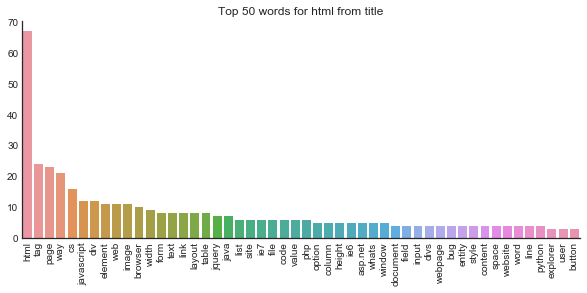

In [234]:
token_index = 2
key = list(sorted_corpfreq_title.keys())[token_index]
corptags_key_title, corptags_value_title = zip(*sorted_corpfreq_title[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_title[:n_element]),
    np.array(corptags_value_title[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_title[:n_element], rotation=90)
ax.set_title('Top 50 words for %s from title' %key)
sns.despine()

### On text body

In [235]:
df_tags_body = pd.DataFrame(
    list(
        zip(df_stags_reduced,
            df_text_reduced.loc[df_stags_reduced.index, "BODY_LEMMATIZED"]))).rename(
                columns={
                    0: "elkey",
                    1: "elvalue"
                })

In [236]:
corpfreq_body, corpstats_body, corpora_body = freq_stats_corpora(df_tags_body)

In [237]:
# sort by values in descending order
sorted_corpfreq_body = defaultdict(list)
cutoff = 1
cutoff_doc = 50
n_most_common = 20
# most frequent words will be the corpora that we use as a dictionary
most_frequent_words = defaultdict(list)

for tag, tagfreq in corpfreq_body.items():
    # only add into sorted_corpfreq if the word occurencces > cutoff_doc
    if sum(list(tagfreq.values())) > cutoff_doc:
    
        most_frequent_words[tag] = set(
            i[0] for i in tagfreq.most_common(n_most_common) if i[1] > cutoff)
        sorted_corpfreq_body[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


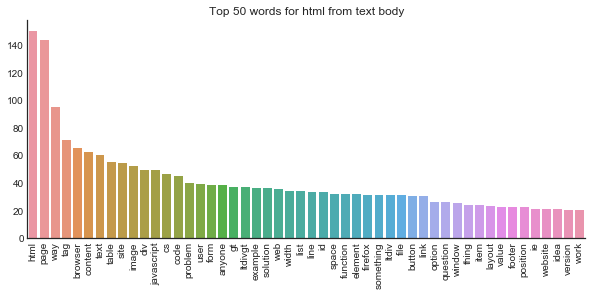

In [238]:
token_index = 2
key = list(sorted_corpfreq_body.keys())[token_index]
corptags_key_body, corptags_value_body = zip(*sorted_corpfreq_body[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_body[:n_element]),
    np.array(corptags_value_body[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_body[:n_element], rotation=90)
ax.set_title(
    'Top 50 words for %s from text body' %key)
sns.despine()

__Observation__:
- From text.body and text.title, the tag words appear the most often in the word distrbution. For example, 
    - {tagword: *python*, word_distrb: {python: 280, way: 120...}
    - {tagword: *performance*, word_distrb: {performance: 120, time: 50...}
    - {tagword: *html*, word_distrb: {html: 150, page: 80...}
- This implies that we can rely on the presence of certain words to correctly predict tags

# Supervised learning: NLTK Naïve Bayes classifer

## Use text body only
### Train/test split
We create a corpus from the train set. This corpus contains the n most frequent words in each tag. We have seen previously that the tag is often found in the text body.

In [306]:
shuffled_df_tags_body = df_tags_body.sample(frac=1, random_state=32)
train_size = int(0.8 * len(shuffled_df_tags_body))

train_crossval_set_body = shuffled_df_tags_body[:train_size]
test_set_body = shuffled_df_tags_body[train_size:]

In [307]:
train_freq_body, train_stats_body, train_corpora_body = freq_stats_corpora(train_crossval_set_body)

### Corpus creation

__Combination of top n words for each tag as corpus__

In [308]:
sorted_train_freq_body = defaultdict(list)
corpus_dict_body = []
n_elements = 5

for tag, tagfreq in train_freq_body.items():
    # only add into sorted_corpfreq if the word occurencces > cutoff_doc
    sorted_train_freq_body[tag] = sorted(
        tagfreq.items(), key=itemgetter(1), reverse=True)
    corpus_dict_body.extend(
        [i[0] for i in sorted_train_freq_body[tag][:n_elements]])

# this corpus will be used to generate features for training
corpus_dict_body = set(corpus_dict_body)

__Use of tags in train set as corpus__


In [ ]:
corpus_dict_tags = set(train_freq_body.keys())

### Feature engineering
From the corpus, we look at tokens of each document. If the token is found in the corpus, then we attribute True to feature 'contain(word)', else False.

In [309]:
def featuregenerator(data, corpus_dict):
    features = {}

    for word in corpus_dict:
        features['contains({})'.format(word)] = (word in set(data))
    return features

In [334]:
train_featuresets_body = []
#n_words = 10
for index, row in train_crossval_set_body.iterrows():
    for key in row.elkey:
        #sorted_elvalue = sorted(
        #    FreqDist(row.elvalue).items(), key=itemgetter(1), reverse=True)
        #fd_elvalue =  FreqDist(row.elvalue)
        #existing_keywords = {i:fd_elvalue[i] for i in set(fd_elvalue.keys()).intersection(most_frequent_words[key])}
        #pdb.set_trace()
        #featuresets.append((dict(sorted_elvalue), key))    
        #featuresets.append(({i:True for i in row.elvalue},key))
        train_featuresets_body.append((featuregenerator(row.elvalue, corpus_dict_body), key))

### Train/crossval split
Proportion of train/crossval:80/20


In [322]:
import random 

random.seed(32)
shuffled_train_featuresets_body = random.sample(train_featuresets_body, len(train_featuresets_body))
train_size = int(0.8 * len(shuffled_train_featuresets_body))

train_body = shuffled_train_featuresets_body[:train_size]
crossval_body = shuffled_train_featuresets_body[train_size:]

### Training

In [324]:
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(train_body)

### Cross validation

In [325]:
# identify error guesses
errors_body = []
for (features, tag) in crossval_body:
    guess = classifier.classify(features)
    if guess != tag:
        errors_body.append( (tag, guess, features) )

In [326]:
# display error guesses
for (tag, guess, features) in errors_body[:10]:
    #print(tag, guess, features)
    print('correct={:}, guess={:}, features={:}'.format(tag, guess, features))

correct=cruisecontrol.net, guess=build-process, features=['contains(management)', 'contains(column)', 'contains(plugins)', 'contains(unit)', 'contains(browser)', 'contains(outlook)', 'contains(structure)', 'contains(event)', 'contains(syntax)', 'contains(platform)', 'contains(address)', 'contains(solution)', 'contains(setup)', 'contains(box)', 'contains(pos0)', 'contains(nothing)', 'contains(foo)', 'contains(month)', 'contains(sharepoint)', 'contains(debug)', 'contains(project)', 'contains(debugger)', 'contains(header)', 'contains(action)', 'contains(task)', 'contains(installer)', 'contains(bash)', 'contains(process)', 'contains(index)', 'contains(javascript)', 'contains(postgresql)', 'contains(path)', 'contains(file)', 'contains(svn)', 'contains(network)', 'contains(report)', 'contains(firefox)', 'contains(jquery)', 'contains(list)', 'contains(shell)', 'contains(git)', 'contains(var)', 'contains(graphic)', 'contains(xp)', 'contains(number)', 'contains(day)', 'contains(linq)', 'contain

### Generation of test featureset

In [338]:
test_body = []

for index, row in test_set_body.iterrows():
    for key in row.elkey:
        #sorted_elvalue = sorted(
        #    FreqDist(row.elvalue).items(), key=itemgetter(1), reverse=True)
        #fd_elvalue =  FreqDist(row.elvalue)
        #existing_keywords = {i:fd_elvalue[i] for i in set(fd_elvalue.keys()).intersection(most_frequent_words[key])}
        #pdb.set_trace()
        #featuresets.append((dict(sorted_elvalue), key))    
        #featuresets.append(({i:True for i in row.elvalue},key))
        test_body.append((featuregenerator(row.elvalue, corpus_dict_body), key))

### Scoring

In [331]:
from nltk.classify import accuracy
train_score_body = accuracy(classifier, train_body)
crossval_score_body = accuracy(classifier, crossval_body)
test_score_body = accuracy(classifier, test_body)

print("Train/test_score:")
print("Train score(accuracy): %.2f" % train_score_body)
print("Crossval score(accuracy): %.2f" % crossval_score_body)
print("Test score(accuracy): %.2f" % test_score_body)

Train/test_score:
Train score(accuracy): 0.33
Crossval score(accuracy): 0.19
Test score(accuracy): 0.24


In [332]:
classifier.show_most_informative_features()

Most Informative Features
         contains(video) = True            video : c#     =    440.4 : 1.0
    contains(powershell) = True           powers : .net   =    394.7 : 1.0
        contains(apache) = True           apache : c#     =    359.0 : 1.0
   contains(tortoisesvn) = True           tortoi : .net   =    354.7 : 1.0
         contains(index) = True           indexi : .net   =    350.0 : 1.0
    contains(sharepoint) = True           sharep : c#     =    336.9 : 1.0
     contains(hibernate) = True           hibern : .net   =    330.7 : 1.0
        contains(delphi) = True           delphi : .net   =    322.8 : 1.0
        contains(jquery) = True           jquery : .net   =    312.8 : 1.0
        contains(backup) = True           backup : c#     =    295.1 : 1.0


__Observation__:
- Train/test score are rather low, we can try to include title in hope of improving the prediction.

## Use body + title
### Feature engineering
- include all freqdist(tokens) from the title when available directly into the featuresets

In [341]:
# train crossval set
train_featuresets_body_title = []
#n_words = 10
for index, row in train_crossval_set_body.iterrows():
    for key in row.elkey:
        #sorted_elvalue = sorted(
        #    FreqDist(row.elvalue).items(), key=itemgetter(1), reverse=True)
        #fd_elvalue =  FreqDist(row.elvalue)
        #existing_keywords = {i:fd_elvalue[i] for i in set(fd_elvalue.keys()).intersection(most_frequent_words[key])}
        #pdb.set_trace()
        #featuresets.append((dict(sorted_elvalue), key))
        #featuresets.append(({i:True for i in row.elvalue},key))
        train_featuresets_body_title.append((featuregenerator(
            row.elvalue + df_tags_title.loc[index].elvalue, corpus_dict_body),
                                             key))

### Train/crossval/test split

In [342]:
random.seed(32)
shuffled_train_featuresets_body_title = random.sample(train_featuresets_body_title, len(train_featuresets_body_title))
train_size = int(0.8 * len(shuffled_train_featuresets_body_title))

train_body_title = shuffled_train_featuresets_body_title[:train_size]
crossval_body_title = shuffled_train_featuresets_body_title[train_size:]

### Training

In [343]:
from nltk import NaiveBayesClassifier

classifier_body_title = NaiveBayesClassifier.train(train_body_title)

### Cross validation

In [344]:
# identify error guesses
errors_body_title  = []
for (features, tag) in crossval_body_title:
    guess = classifier_body_title.classify(features)
    if guess != tag:
        errors_body_title.append( (tag, guess, features) )

In [345]:
# display error guesses
for (tag, guess, features) in errors_body_title[:10]:
    print('correct={:}, guess={:}, features={:}'.format(tag, guess, list(features)))

correct=cruisecontrol.net, guess=build-process, features=['contains(management)', 'contains(column)', 'contains(plugins)', 'contains(unit)', 'contains(browser)', 'contains(outlook)', 'contains(structure)', 'contains(event)', 'contains(syntax)', 'contains(platform)', 'contains(address)', 'contains(solution)', 'contains(setup)', 'contains(box)', 'contains(pos0)', 'contains(nothing)', 'contains(foo)', 'contains(month)', 'contains(sharepoint)', 'contains(debug)', 'contains(project)', 'contains(debugger)', 'contains(header)', 'contains(action)', 'contains(task)', 'contains(installer)', 'contains(bash)', 'contains(process)', 'contains(index)', 'contains(javascript)', 'contains(postgresql)', 'contains(path)', 'contains(file)', 'contains(svn)', 'contains(network)', 'contains(report)', 'contains(firefox)', 'contains(jquery)', 'contains(list)', 'contains(shell)', 'contains(git)', 'contains(var)', 'contains(graphic)', 'contains(xp)', 'contains(number)', 'contains(day)', 'contains(linq)', 'contain

### Generation of test featureset

In [346]:
test_body_title = []

for index, row in test_set_body.iterrows():
    for key in row.elkey:
        #sorted_elvalue = sorted(
        #    FreqDist(row.elvalue).items(), key=itemgetter(1), reverse=True)
        #fd_elvalue =  FreqDist(row.elvalue)
        #existing_keywords = {i:fd_elvalue[i] for i in set(fd_elvalue.keys()).intersection(most_frequent_words[key])}
        #pdb.set_trace()
        #featuresets.append((dict(sorted_elvalue), key))
        #featuresets.append(({i:True for i in row.elvalue},key))
        test_body_title.append(
            (featuregenerator(row.elvalue + df_tags_title.loc[index].elvalue,
                              corpus_dict_body), key))

### Scoring

In [347]:
from nltk.classify import accuracy
train_score_body_title = accuracy(classifier, train_body_title)
crossval_score_body_title = accuracy(classifier, crossval_body_title)
test_score_body_title = accuracy(classifier, test_body_title)

print("Train/test_score:")
print("Train score(accuracy): %.2f" % train_score_body_title)
print("Crossval score(accuracy): %.2f" % crossval_score_body_title)
print("Test score(accuracy): %.2f" % test_score_body_title)

Train/test_score:
Train score(accuracy): 0.37
Crossval score(accuracy): 0.23
Test score(accuracy): 0.28


__Observation__:
- Naïve Bayes model doesn't return a good test score. Possible explorations to increase the test score:
    - Use another model
    - Include more data
    - Feature enginnering